In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import glob

In [3]:
csv_files = glob.glob('stock-time-series-20050101-to-20171231/*.csv')
df_list = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(df_list, ignore_index=True)

In [4]:
common_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df_list = [pd.read_csv(file)[common_columns] for file in csv_files]

In [5]:
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df = combined_df.sort_values('Date').reset_index(drop=True)

In [6]:
combined_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195005 entries, 0 to 195004
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    195005 non-null  datetime64[ns]
 1   Open    194931 non-null  float64       
 2   High    194976 non-null  float64       
 3   Low     194946 non-null  float64       
 4   Close   195005 non-null  float64       
 5   Volume  195005 non-null  int64         
 6   Name    195005 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 10.4+ MB


In [7]:
combined_df.ffill(inplace=True)
#combined_df.isnull().sum()


In [8]:
combined_df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-03,126.70,129.44,124.23,128.87,6188700,GS
2,2006-01-03,17.21,17.49,17.18,17.45,55432166,CSCO
3,2006-01-03,40.39,41.45,39.77,41.24,8960100,HD
4,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM


In [9]:
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

In [10]:
combined_df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-03,126.70,129.44,124.23,128.87,6188700,GS
2,2006-01-03,17.21,17.49,17.18,17.45,55432166,CSCO
3,2006-01-03,40.39,41.45,39.77,41.24,8960100,HD
4,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM


In [11]:
#sns.lineplot(data=combined_df, x='Date', y='Close')
#plt.title('Stock Closing Prices Over Time')

In [12]:
#sns.lineplot(data=combined_df[combined_df['Name'] == 'IBM'], x='Date', y='Close')
#plt.title('Stock Closing Prices Over Time (IBM)')
#plt.show()

In [13]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler

In [14]:
IBM_df = combined_df[combined_df['Name'] == 'IBM'].copy()
IBM_df['Date'] = pd.to_datetime(IBM_df['Date'])

IBM_df = IBM_df.sort_values('Date').reset_index(drop=True)

X = IBM_df.drop(columns=['Date', 'Close','Name'])
y = IBM_df['Close']

n=len(IBM_df)
train_size = int(n * 0.7)
val_size = int(n * 0.15)
test_size = n - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]
X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
print(f"Validation set: {len(X_val)} samples ({X_val.index[0]} to {X_val.index[-1]})")
print(f"Test set: {len(X_test)} samples ({X_test.index[0]} to {X_test.index[-1]})")

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train.values.reshape(-1, 1))
X_val_scaled = scaler.transform(X_val.values.reshape(-1, 1))
X_test_scaled = scaler.transform(X_test.values.reshape(-1, 1))


Train size: 4403, Validation size: 943, Test size: 945
Validation set: 943 samples (4403 to 5345)
Test set: 945 samples (5346 to 6290)


In [15]:
def create_sequences(data, seq_length):
    xs ,ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 60
X_train_seq, y_train_seq = create_sequences(X_train_scaled, SEQ_LENGTH)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, SEQ_LENGTH)

# Reshape for PyTorch LSTM: (batch_size, seq_length, num_features)
# If only using 'Close' price, num_features = 1
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], 1)
X_val_seq = X_val_seq.reshape(X_val_seq.shape[0], X_val_seq.shape[1], 1)
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], 1)

In [16]:
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.FloatTensor(y_train_seq)
X_val_tensor = torch.FloatTensor(X_val_seq)
y_val_tensor = torch.FloatTensor(y_val_seq)
X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [17]:
import torch.nn as nn

class StockPredictorLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob=0.2):
        super(StockPredictorLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        # batch_first=True means input/output tensors are (batch, seq, feature)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_dim)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0)) # out: (batch_size, seq_length, hidden_dim)
        # We only want the output from the last time step
        out = self.fc(out[:, -1, :]) # out: (batch_size, output_dim)
        return out

INPUT_DIM = 1 # Number of features (just 'Close' price initially)
HIDDEN_DIM = 64 # Hyperparameter
NUM_LAYERS = 2  # Hyperparameter
OUTPUT_DIM = 1 # Predicting one value (next day's price)
DROPOUT = 0.2

model = StockPredictorLSTM(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS, OUTPUT_DIM, DROPOUT)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

StockPredictorLSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [21]:
NUM_EPOCHS = 50 # Hyperparameter
train_losses = []
val_losses = []

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Hyperparameter

for epoch in range(NUM_EPOCHS):
    model.train() # Set model to training mode
    epoch_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval() # Set model to evaluation mode
    epoch_val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Optional: Implement early stopping based on val_loss

Epoch [1/50], Train Loss: 0.0050, Val Loss: 0.0009
Epoch [2/50], Train Loss: 0.0010, Val Loss: 0.0007
Epoch [3/50], Train Loss: 0.0009, Val Loss: 0.0007
Epoch [4/50], Train Loss: 0.0008, Val Loss: 0.0007
Epoch [5/50], Train Loss: 0.0008, Val Loss: 0.0007
Epoch [6/50], Train Loss: 0.0008, Val Loss: 0.0008
Epoch [7/50], Train Loss: 0.0008, Val Loss: 0.0007
Epoch [8/50], Train Loss: 0.0008, Val Loss: 0.0008
Epoch [9/50], Train Loss: 0.0008, Val Loss: 0.0006
Epoch [10/50], Train Loss: 0.0008, Val Loss: 0.0007
Epoch [11/50], Train Loss: 0.0008, Val Loss: 0.0006
Epoch [12/50], Train Loss: 0.0008, Val Loss: 0.0006
Epoch [13/50], Train Loss: 0.0008, Val Loss: 0.0007
Epoch [14/50], Train Loss: 0.0008, Val Loss: 0.0006
Epoch [15/50], Train Loss: 0.0008, Val Loss: 0.0006
Epoch [16/50], Train Loss: 0.0008, Val Loss: 0.0006
Epoch [17/50], Train Loss: 0.0008, Val Loss: 0.0006
Epoch [18/50], Train Loss: 0.0008, Val Loss: 0.0007
Epoch [19/50], Train Loss: 0.0008, Val Loss: 0.0006
Epoch [20/50], Train 

In [23]:
# In cell id="2302e30c"

model.eval()
with torch.no_grad():
    test_inputs = X_test_tensor.to(device)
    predicted_prices_scaled = model(test_inputs).cpu().numpy()

# Inverse transform the predictions and actual values to their original scale
predicted_prices = scaler.inverse_transform(predicted_prices_scaled)

# Corrected line:
# Use y_test_seq, which are the scaled target values corresponding to the predictions.
# y_test_seq is a NumPy array, so .reshape() will work.
# Its values are consistent with how 'scaler' was fit and used for X_test_scaled.
actual_prices = scaler.inverse_transform(y_test_seq.reshape(-1, 1))

--- Test Set Evaluation Metrics ---
Mean Squared Error (MSE): 833195229321.6088
Root Mean Squared Error (RMSE): 912795.2834
Mean Absolute Error (MAE): 269677.6931
R-squared (R²): 0.8200
Mean Absolute Percentage Error (MAPE): 34234.54%

Note: These metrics evaluate the prediction of the next value in the flattened sequence of 'Open', 'High', 'Low', 'Volume' features, based on your current data preprocessing.


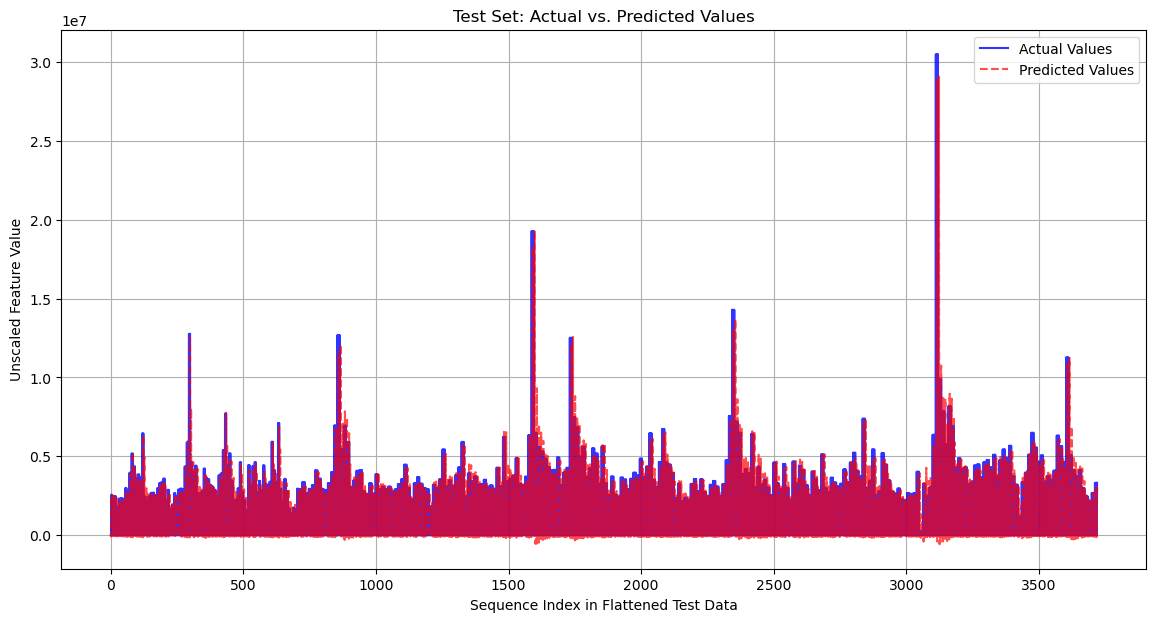

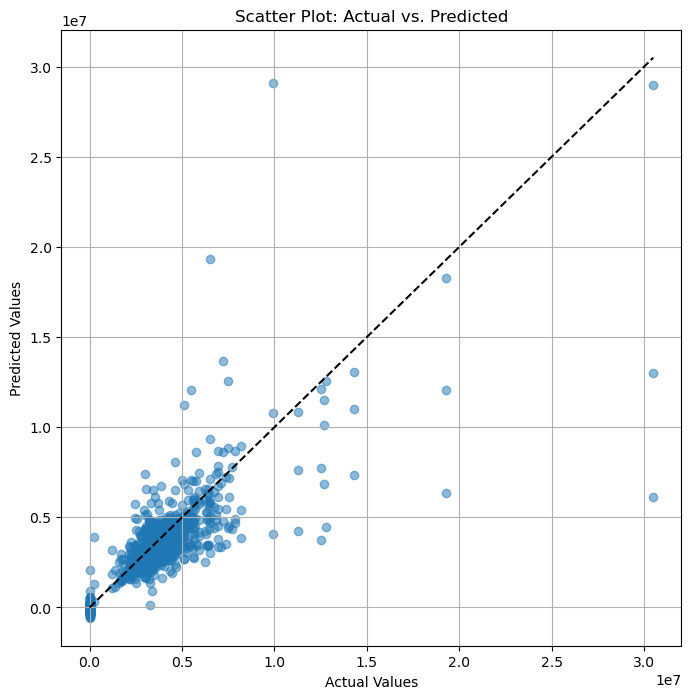

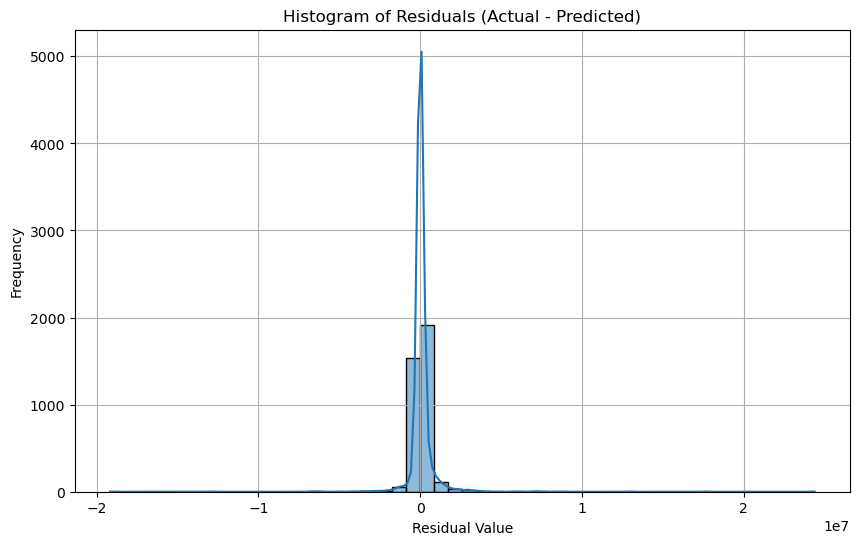

Basic statistics of residuals:
  Mean: 89061.8923
  Std Dev: 908439.9863
  Min: -19168665.0000
  Max: 24378743.5000


In [24]:
# This cell should follow the cell with id="2302e30c" after correction

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'predicted_prices_scaled', 'y_test_seq', and 'scaler' are available
# from the corrected previous cell (id="2302e30c")

# If not already done in the previous cell:
# model.eval()
# with torch.no_grad():
#     test_inputs = X_test_tensor.to(device)
#     predicted_prices_scaled = model(test_inputs).cpu().numpy()

# predicted_prices = scaler.inverse_transform(predicted_prices_scaled)
# actual_prices = scaler.inverse_transform(y_test_seq.reshape(-1, 1)) # y_test_seq are the targets

# Ensure they are 1D arrays for sklearn metrics
predicted_values_flat = predicted_prices.flatten()
actual_values_flat = actual_prices.flatten()

# --- Calculate Metrics ---
mse_test = mean_squared_error(actual_values_flat, predicted_values_flat)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(actual_values_flat, predicted_values_flat)
r2_test = r2_score(actual_values_flat, predicted_values_flat)

print(f"--- Test Set Evaluation Metrics ---")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"R-squared (R²): {r2_test:.4f}")

# Mean Absolute Percentage Error (MAPE)
# MAPE can be problematic if actual_values_flat contains zeros.
if not np.any(actual_values_flat == 0):
    mape_test = np.mean(np.abs((actual_values_flat - predicted_values_flat) / actual_values_flat)) * 100
    print(f"Mean Absolute Percentage Error (MAPE): {mape_test:.2f}%")
else:
    # Calculate MAPE for non-zero actual values only if you wish, or report it's not fully applicable
    non_zero_actuals_mask = actual_values_flat != 0
    if np.any(non_zero_actuals_mask):
        mape_test_nz = np.mean(np.abs((actual_values_flat[non_zero_actuals_mask] - predicted_values_flat[non_zero_actuals_mask]) / actual_values_flat[non_zero_actuals_mask])) * 100
        print(f"Mean Absolute Percentage Error (MAPE) for non-zero actuals: {mape_test_nz:.2f}%")
    else:
        print("MAPE cannot be calculated as all actual values are zero.")
    print("Note: Standard MAPE is sensitive to zero or near-zero actual values.")

print("\nNote: These metrics evaluate the prediction of the next value in the flattened sequence of 'Open', 'High', 'Low', 'Volume' features, based on your current data preprocessing.")

# --- Visualizations to 'see' the error ---

# 1. Plot of Actual vs. Predicted values
plt.figure(figsize=(14, 7))
plt.plot(actual_values_flat, label='Actual Values', color='blue', alpha=0.8)
plt.plot(predicted_values_flat, label='Predicted Values', color='red', linestyle='--', alpha=0.7)
plt.title('Test Set: Actual vs. Predicted Values')
plt.xlabel('Sequence Index in Flattened Test Data')
plt.ylabel('Unscaled Feature Value')
plt.legend()
plt.grid(True)
plt.show()

# 2. Scatter plot of Actual vs. Predicted values
plt.figure(figsize=(8, 8))
plt.scatter(actual_values_flat, predicted_values_flat, alpha=0.5)
plt.plot([min(actual_values_flat), max(actual_values_flat)], [min(actual_values_flat), max(actual_values_flat)], '--k') # Diagonal line
plt.title('Scatter Plot: Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

# 3. Histogram of Residuals (Errors)
residuals = actual_values_flat - predicted_values_flat
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.title('Histogram of Residuals (Actual - Predicted)')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(f"Basic statistics of residuals:")
print(f"  Mean: {np.mean(residuals):.4f}")
print(f"  Std Dev: {np.std(residuals):.4f}")
print(f"  Min: {np.min(residuals):.4f}")
print(f"  Max: {np.max(residuals):.4f}")